## Setup, Loading Data and CDFs

In [8]:
DATA_NAME = 'approx1e5-pastis-wavelet-red' # Dataset Format: size-name-transform-channel

In [9]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Volumes/SSD/hbmv/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/red'

In [10]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [11]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
#group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

In [12]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
all_cdfs_df.head()

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

## Bootstrapping the Variance and Kurtosis

In [13]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [14]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:15<00:00, 6360.70it/s]


Layer 3


100%|██████████| 100000/100000 [00:20<00:00, 4777.63it/s]


Layer 4


100%|██████████| 100000/100000 [00:20<00:00, 4807.70it/s]


Layer 5


100%|██████████| 100000/100000 [00:20<00:00, 4788.53it/s]


Layer 6


100%|██████████| 100000/100000 [00:21<00:00, 4723.65it/s]


Layer 7


100%|██████████| 100000/100000 [00:20<00:00, 4774.34it/s]


Layer 8


100%|██████████| 100000/100000 [00:20<00:00, 4776.80it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  
layer                             
2        5.295139         3180.0  
3        4.080620        12720.0  
4        4.774097        50880.0  
5        6.967747       203520.0  
6       10.394491       814080.0  
7       15.655435      3256320.0  
8       31.192720     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [15]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

####
Layer  2


100%|██████████| 55966/55966 [00:05<00:00, 11115.11it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 3180, Without approximation : 3180.0
####
Layer  3


100%|██████████| 55966/55966 [00:17<00:00, 3253.34it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 12720, Without approximation : 12720.0
####
Layer  4


100%|██████████| 55966/55966 [01:01<00:00, 911.54it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 50880, Without approximation : 50880.0
####
Layer  5


100%|██████████| 55966/55966 [02:03<00:00, 452.51it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 203520.0
####
Layer  6


100%|██████████| 55966/55966 [02:01<00:00, 460.42it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 814080.0
####
Layer  7


100%|██████████| 55966/55966 [02:02<00:00, 455.82it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 3256320.0
####
Layer  8


100%|██████████| 55966/55966 [02:04<00:00, 450.84it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13025280.0


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        5.295139         3180.0       0.12         7.00   4.266123e-13   
3        4.080620        12720.0       0.36         1.10   1.649470e+00   
4        4.774097        50880.0       0.59        -0.20   3.224124e+01   
5        6.967747       203520.0       0.50        -0.43   5.335612e+00   
6       10.394491       814080.0       0.35        -0.40   1.355916e-01   
7       15.655435      3256320.0       0.12         1.20   2.095827e-12   
8       31.192720     13025280.0       0.12         1.40   2.048151e-13   

       kstest_stat_initial  kstest_stat_cutoff_0.05  
layer                                                
2                 0.017199                 0.024030  
3                 0.003638                 0.012029  
4                 0.005465                 0.006018  
5                 0.001712                 0.003010  
6                 0.004030                 0.001505  
7                 0.009590                 0.000753  
8                 0.029580                 0.000376

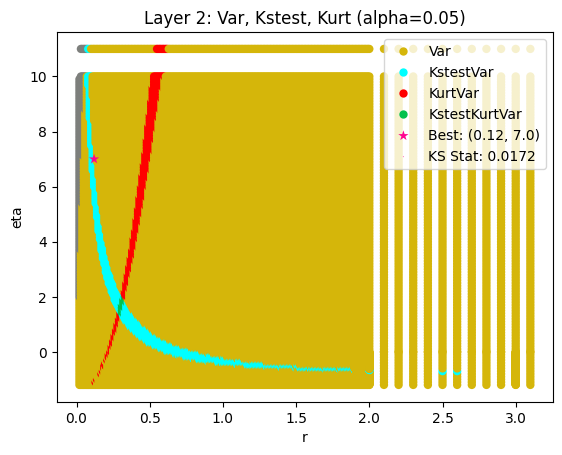

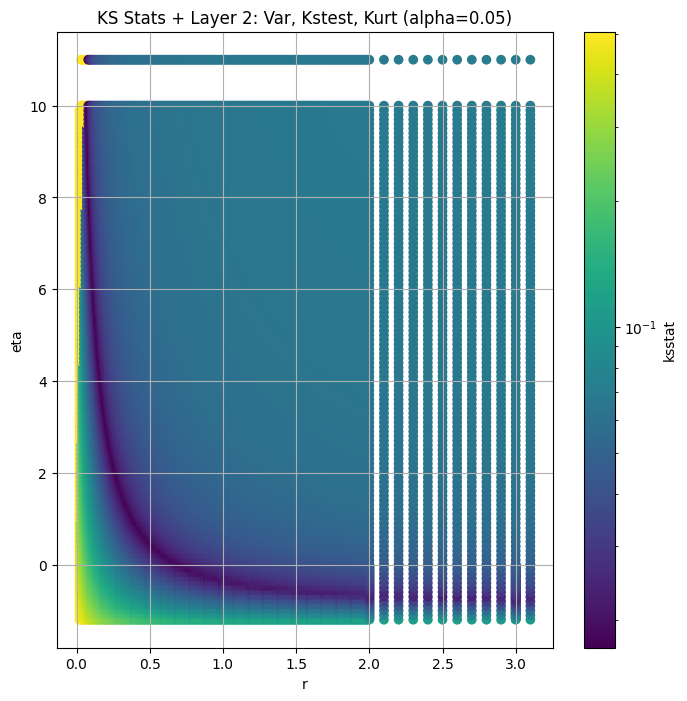

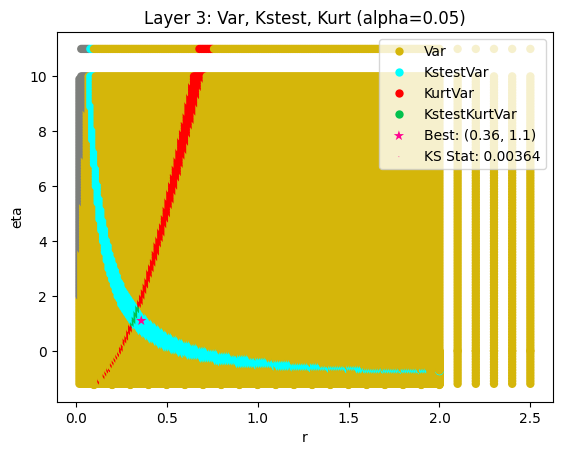

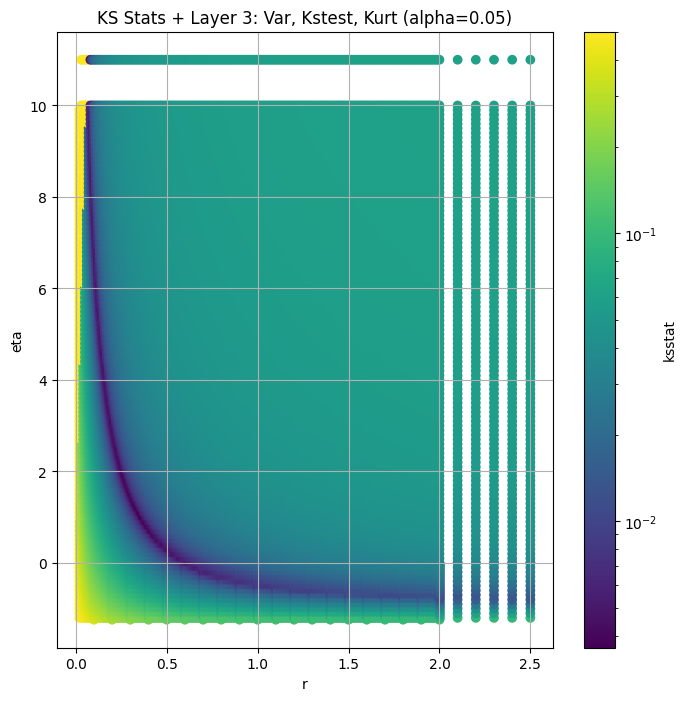

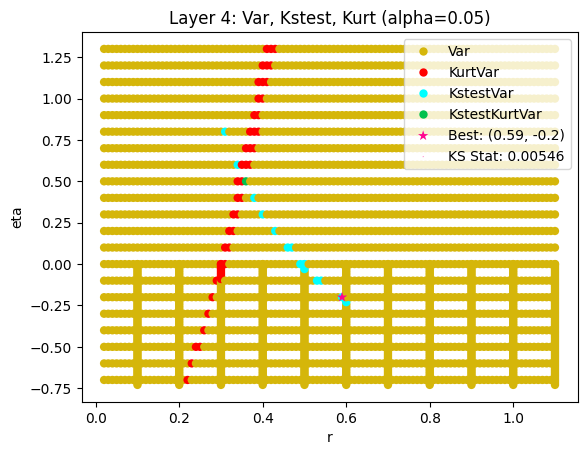

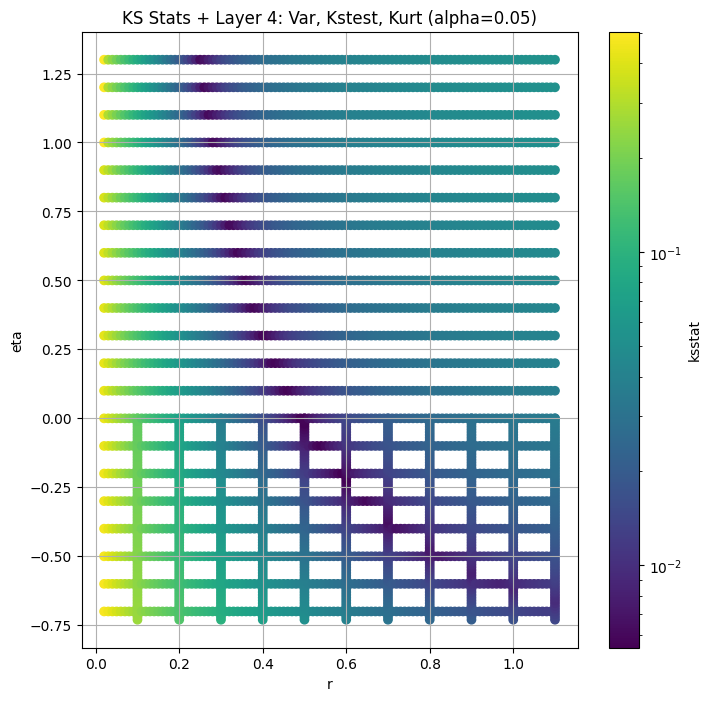

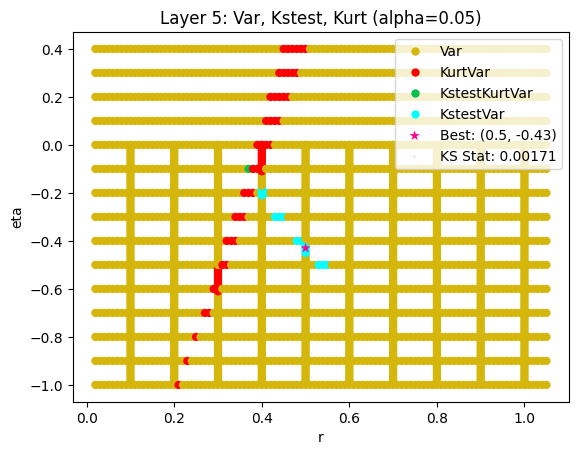

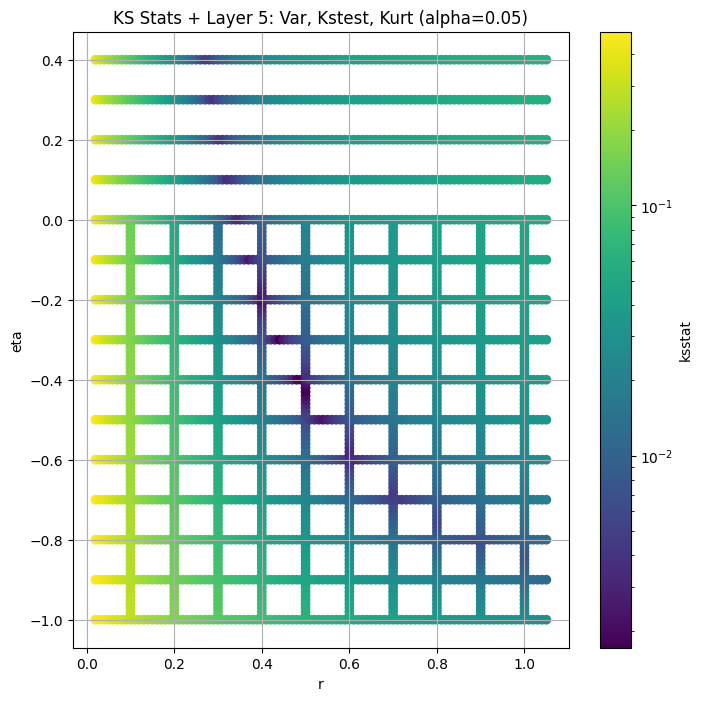

0
6 after 0


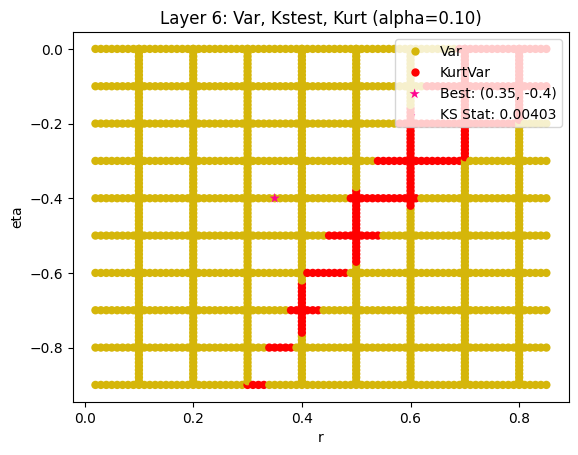

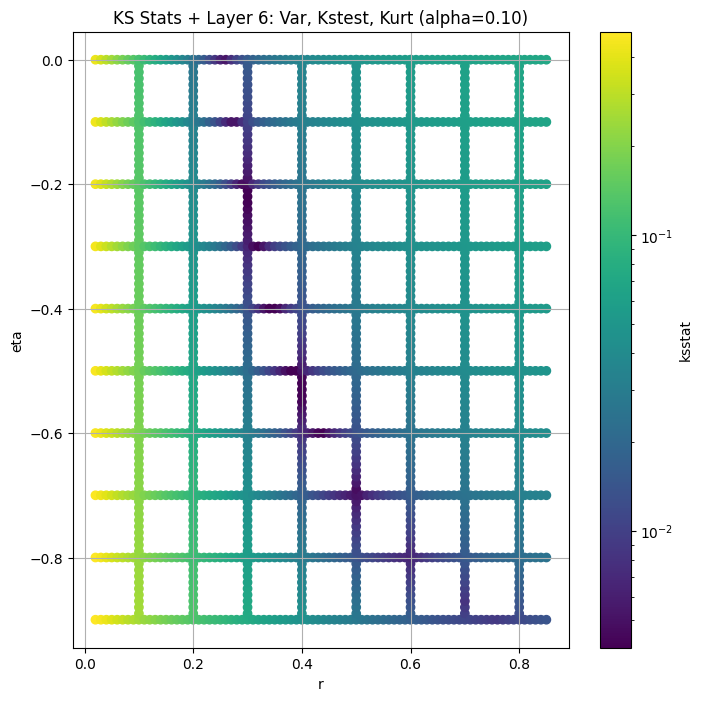

0
7 after 0


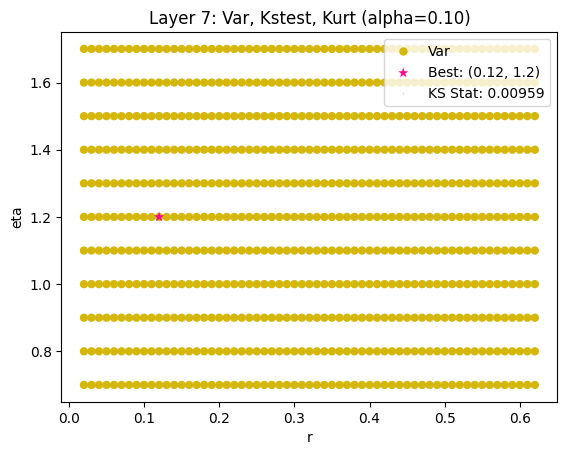

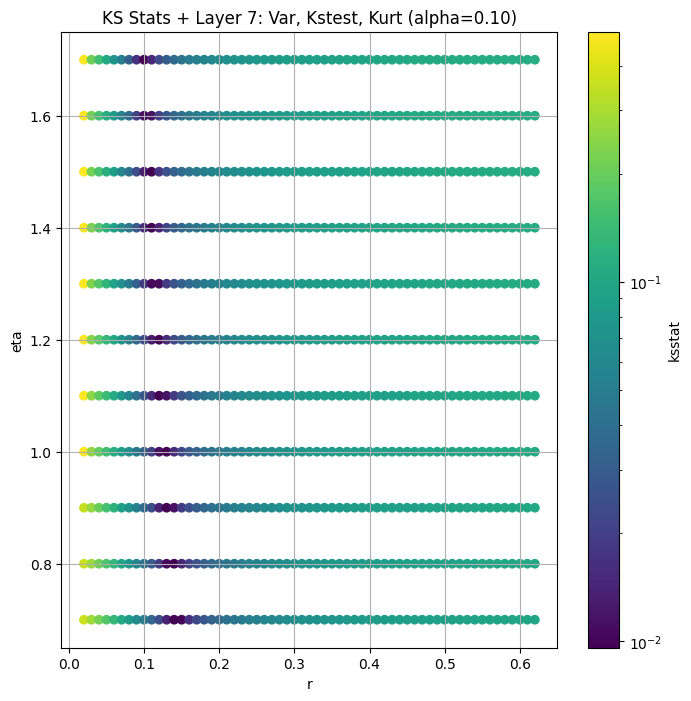

0
8 after 0


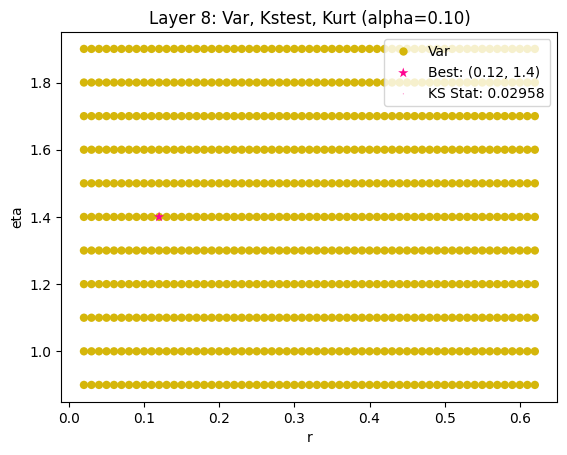

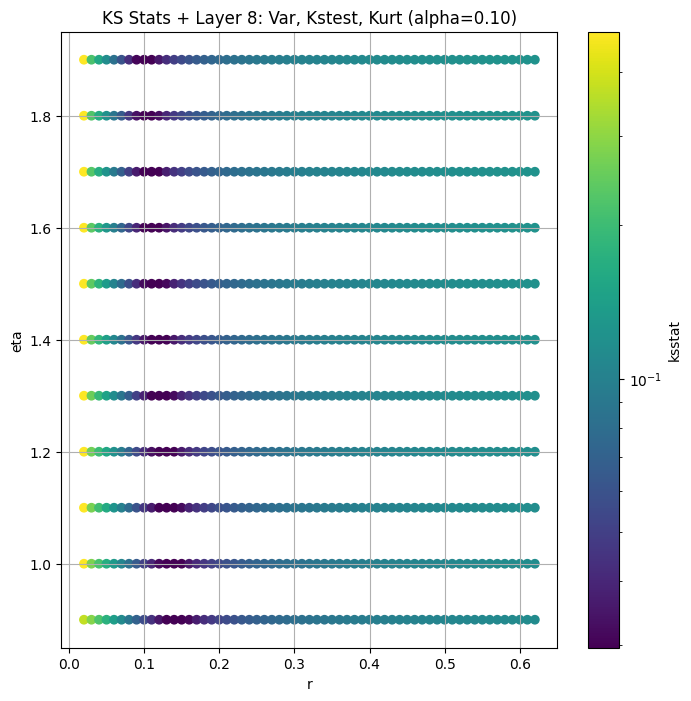

In [16]:
for i, group in enumerate(GROUPS):

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        
        if sum(group_cdf_df_dict[group]['pass_kstest'] & group_cdf_df_dict[group]['pass_kurt']) == 0:
                print(sum(group_cdf_df_dict[group]['pass_kstest']))
                cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.10)
                group_cdf_df_dict[group]['pass_kstest'] = group_cdf_df_dict[group]['ksstat'].apply(lambda x: True if x < cutoff else False)
                print(group, "after", sum(group_cdf_df_dict[group]['pass_kstest']))

                fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                                plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} (alpha=0.10)", 
                                target_var = None,
                                best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
                                best_ksstat= master_df.loc[group, 'kstest_stat_initial']
                                )
        else: 
                fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                                plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} (alpha=0.05)", 
                                target_var = None,
                                best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
                                best_ksstat= master_df.loc[group, 'kstest_stat_initial']
                                )
        

        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
        
        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

### Search over $\eta=0$

In [17]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

  0%|          | 0/369 [00:00<?, ?it/s]

100%|██████████| 369/369 [00:00<00:00, 8630.35it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 3453.44it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 889.21it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 449.08it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 450.69it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 440.99it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 447.57it/s]

Finding Minimum after computing 369 CDFs


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        5.295139         3180.0       0.12         7.00   4.266123e-13   
3        4.080620        12720.0       0.36         1.10   1.649470e+00   
4        4.774097        50880.0       0.59        -0.20   3.224124e+01   
5        6.967747       203520.0       0.50        -0.43   5.335612e+00   
6       10.394491       814080.0       0.35        -0.40   1.355916e-01   
7       15.655435      3256320.0       0.12         1.20   2.095827e-12   
8       31.192720     13025280.0       0.12         1.40   2.048151e-13   

       kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
layer                                                              
2                 0.017199                 0.024030         6.00   
3                 0.003638                 0.012029         5.90   
4                 0.005465                 0.006018         5.80   
5                 0.001712                 0.003010         5.80   
6                 0.004030                 0.001505         5.80   
7                 0.009590                 0.000753         5.80   
8                 0.029580                 0.000376         0.03   

       best_scale_eta0  kstest_stat_eta0  
layer                                     
2         3.693983e-01          0.331817  
3         3.691530e-01          0.384936  
4         3.688883e-01          0.425627  
5         3.688883e-01          0.455965  
6         3.688883e-01          0.475680  
7         3.688883e-01          0.486949  
8         6.367404e-62          0.473620

## Optimization

In [18]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(0.112, 6.99), 50 of 420
(0.114, 7.09), 100 of 420
(0.117, 6.99), 150 of 420
(0.119, 7.09), 200 of 420
(0.122, 6.99), 250 of 420
(0.124, 7.09), 300 of 420
(0.127, 6.99), 350 of 420
(0.129, 7.09), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 12327.90it/s]

Finding Minimum after computing 420 CDFs
Iter 1 layer 2 best parameters: ((0.12, 6.99), 0.01714714005658713)


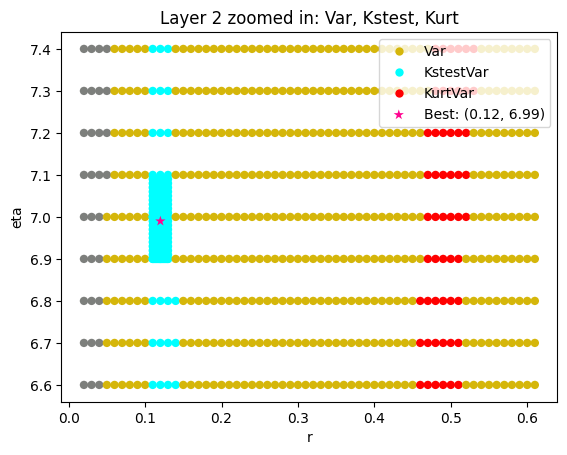

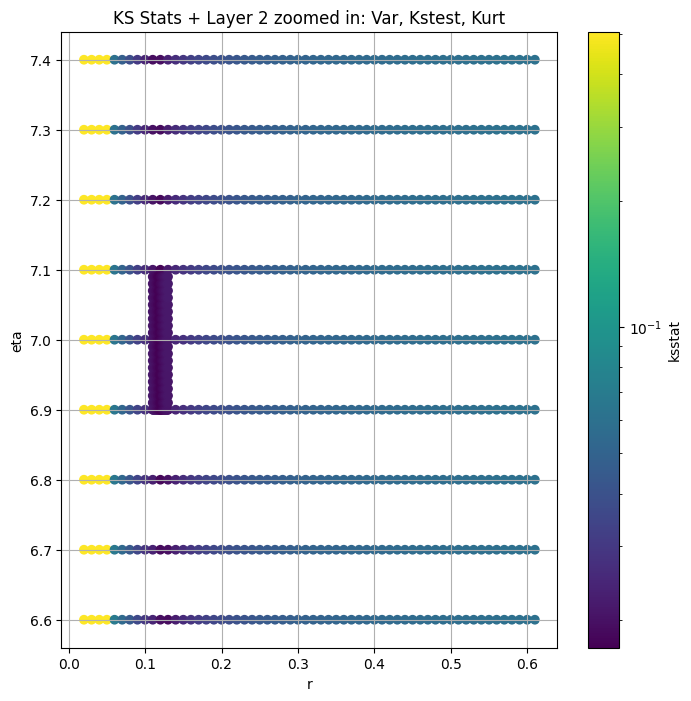

Layer 3
(0.352, 1.07), 50 of 441
(0.354, 1.15), 100 of 441
(0.357, 1.02), 150 of 441
(0.359, 1.1), 200 of 441
(0.361, 1.18), 250 of 441
(0.364, 1.05), 300 of 441
(0.366, 1.13), 350 of 441
(0.369, 1.0), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 3503.78it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((0.37, 1.01), 0.0035211935176886477)


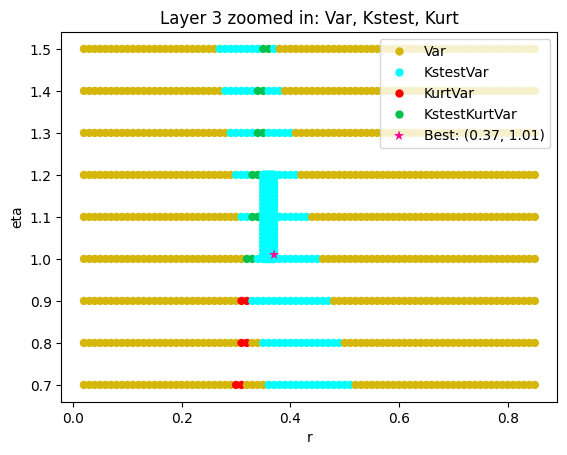

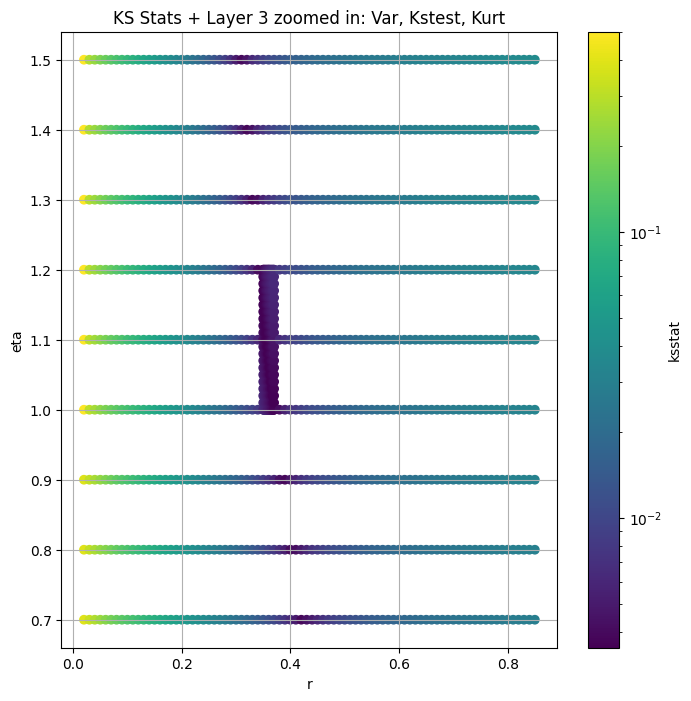

Layer 4
(0.582, -0.23), 50 of 441
(0.584, -0.15), 100 of 441
(0.587, -0.28), 150 of 441
(0.589, -0.2), 200 of 441
(0.591, -0.12), 250 of 441
(0.594, -0.25), 300 of 441
(0.596, -0.17), 350 of 441
(0.599, -0.3), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 895.75it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.589, -0.2), 0.005451913633147454)


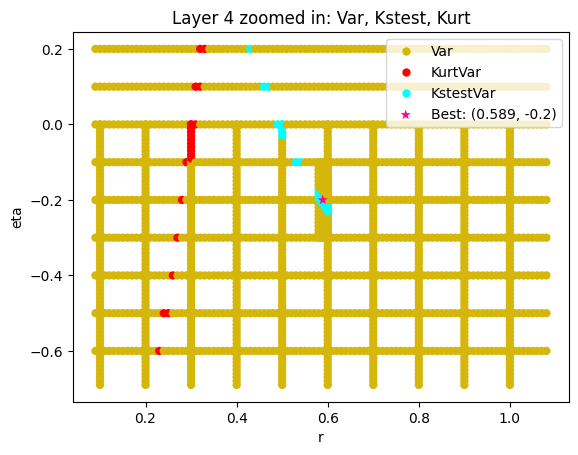

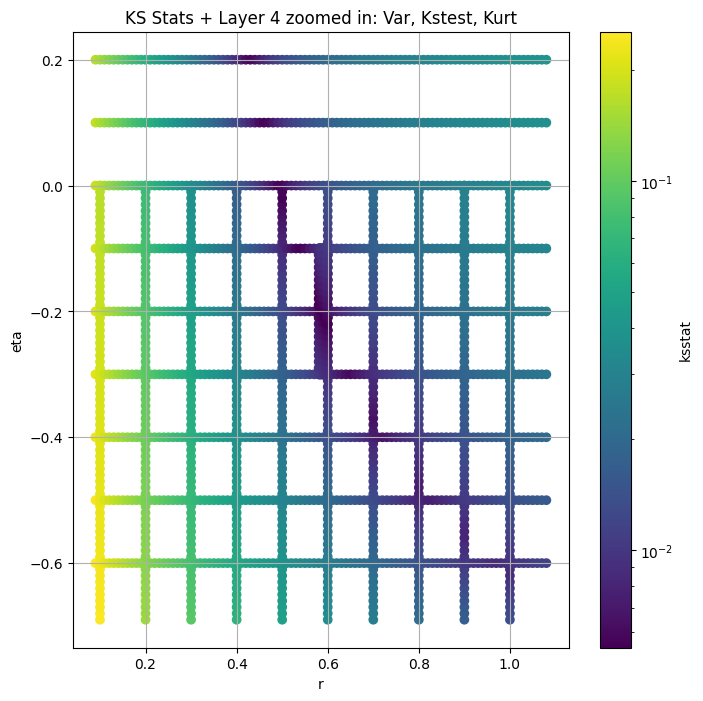

Layer 5
(0.42, -0.433), 50 of 420
(0.44, -0.425), 100 of 420
(0.47, -0.438), 150 of 420
(0.49, -0.43), 200 of 420
(0.51, -0.422), 250 of 420
(0.54, -0.435), 300 of 420
(0.56, -0.427), 350 of 420
(0.59, -0.44), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 455.08it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 5 best parameters: ((0.5, -0.427), 0.0016145390239825225)


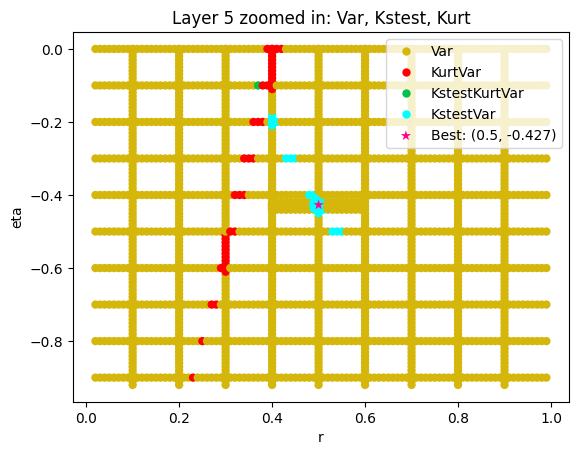

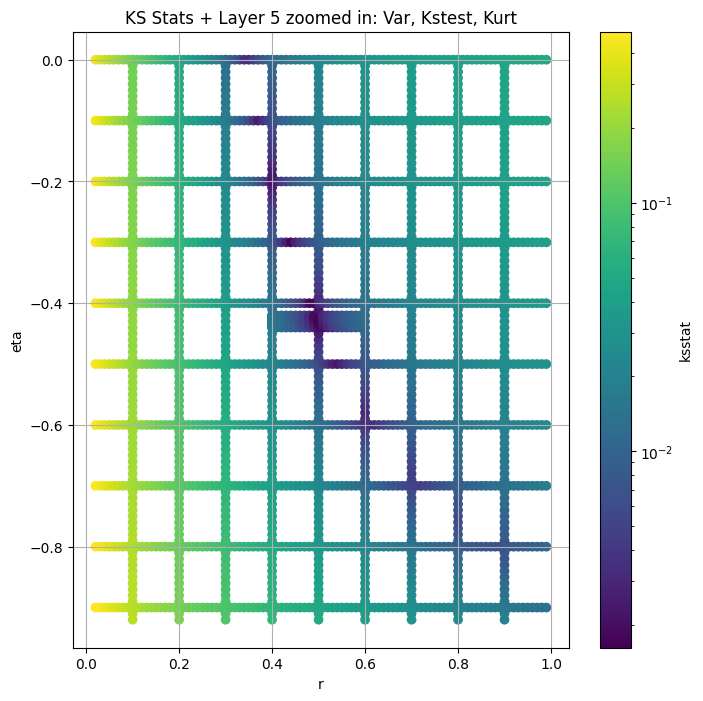

Layer 6
(0.342, -0.41), 50 of 420
(0.344, -0.31), 100 of 420
(0.347, -0.41), 150 of 420
(0.349, -0.31), 200 of 420
(0.352, -0.41), 250 of 420
(0.354, -0.31), 300 of 420
(0.357, -0.41), 350 of 420
(0.359, -0.31), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 464.50it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 6 best parameters: ((0.355, -0.45), 0.004029999999998091)


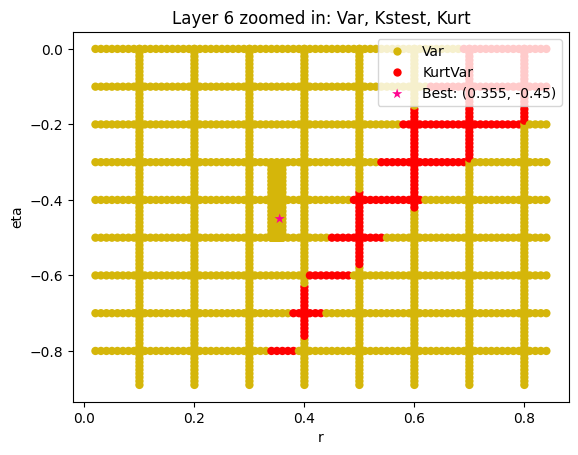

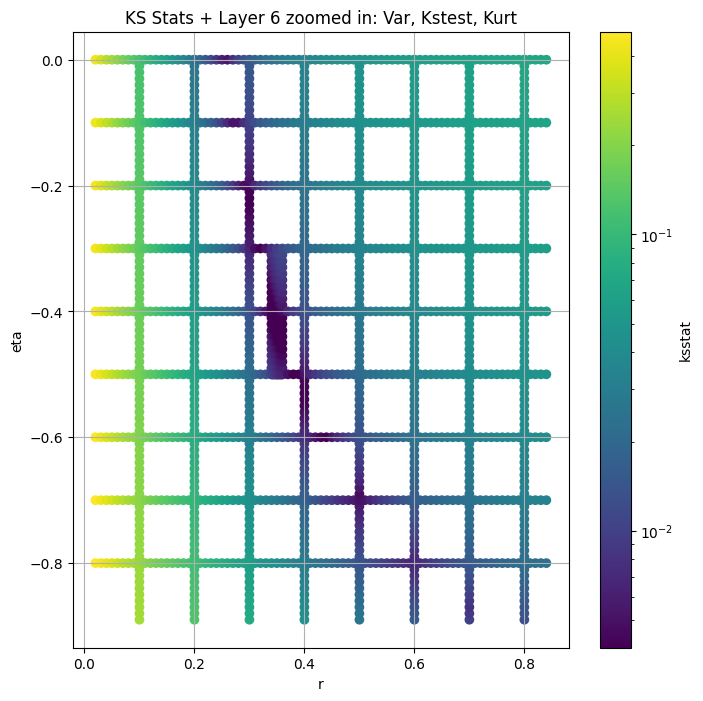

Layer 7
(0.112, 1.17), 50 of 441
(0.114, 1.25), 100 of 441
(0.117, 1.12), 150 of 441
(0.119, 1.2), 200 of 441
(0.121, 1.28), 250 of 441
(0.124, 1.15), 300 of 441
(0.126, 1.23), 350 of 441
(0.129, 1.1), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 476.33it/s]

Finding Minimum after computing 441 CDFs
Iter 1 layer 7 best parameters: ((0.118, 1.22), 0.009589999999996324)


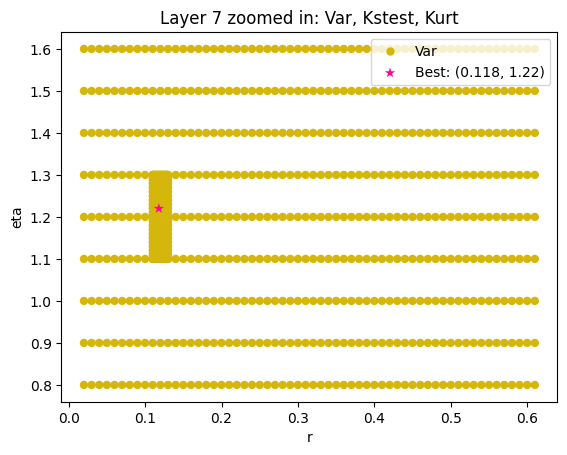

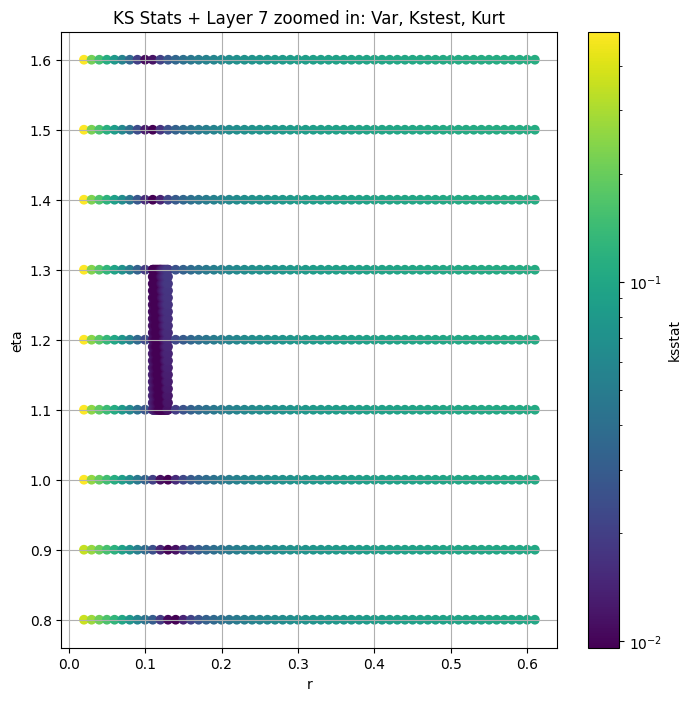

Layer 8
(0.112, 1.37), 50 of 441
(0.114, 1.45), 100 of 441
(0.117, 1.32), 150 of 441
(0.119, 1.4), 200 of 441
(0.121, 1.48), 250 of 441
(0.124, 1.35), 300 of 441
(0.126, 1.43), 350 of 441
(0.129, 1.3), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 466.29it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 8 best parameters: ((0.118, 1.34), 0.02957999999999139)


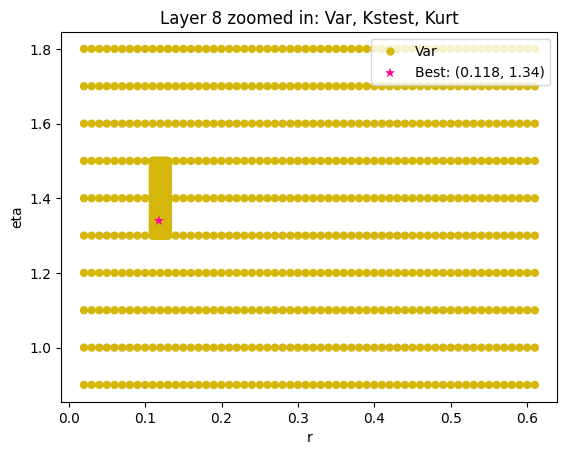

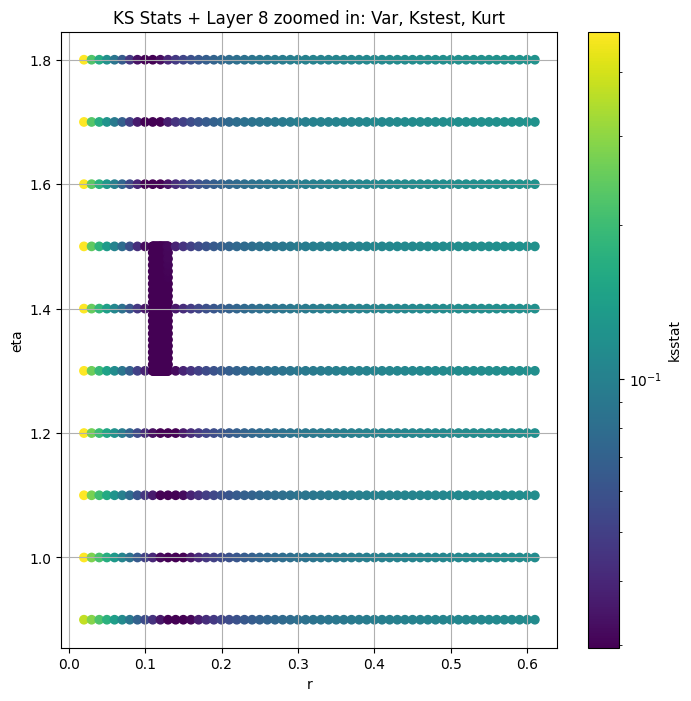

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        5.295139         3180.0       0.12         7.00   4.266123e-13  ...   
3        4.080620        12720.0       0.36         1.10   1.649470e+00  ...   
4        4.774097        50880.0       0.59        -0.20   3.224124e+01  ...   
5        6.967747       203520.0       0.50        -0.43   5.335612e+00  ...   
6       10.394491       814080.0       0.35        -0.40   1.355916e-01  ...   
7       15.655435      3256320.0       0.12         1.20   2.095827e-12  ...   
8       31.192720     13025280.0       0.12         1.40   2.048151e-13  ...   

       kstest_stat_eta0  best_r  best_eta    best_scale  kstest_stat_best  \
layer                                                                       
2              0.331817   0.120     6.990  4.306139e-13          0.017147   
3              0.384936   0.370     1.010  2.273720e+00          0.003521   
4              0.425627   0.589    -0.200  3.204585e+01          0.005452   
5              0.455965   0.500    -0.427  5.310546e+00          0.001615   
6              0.475680   0.355    -0.450  1.665070e-01          0.004030   
7              0.486949   0.118     1.220  1.083370e-12          0.009590   
8              0.473620   0.118     1.340  1.293591e-13          0.029580   

       iter1_r  iter1_eta  kstest_stat_iter1  pass_all  n_pval_0.05  
layer                                                                
2        0.120      6.990           0.017147      True         6034  
3        0.370      1.010           0.003521      True       144888  
4        0.589     -0.200           0.005452      True        64395  
5        0.500     -0.427           0.001615      True       686880  
6        0.355     -0.450           0.004030     False       114480  
7        0.118      1.220           0.009590     False        19080  
8        0.118      1.340           0.029580     False         2011  

[7 rows x 24 columns]

In [19]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales= temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp = group_cdf_df_dict[group]
            master_df.loc[group, 'pass_all'] = np.any(temp['pass_kstest'] & temp['pass_var'] & temp['pass_kurt'])
            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.5
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']

            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

            
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

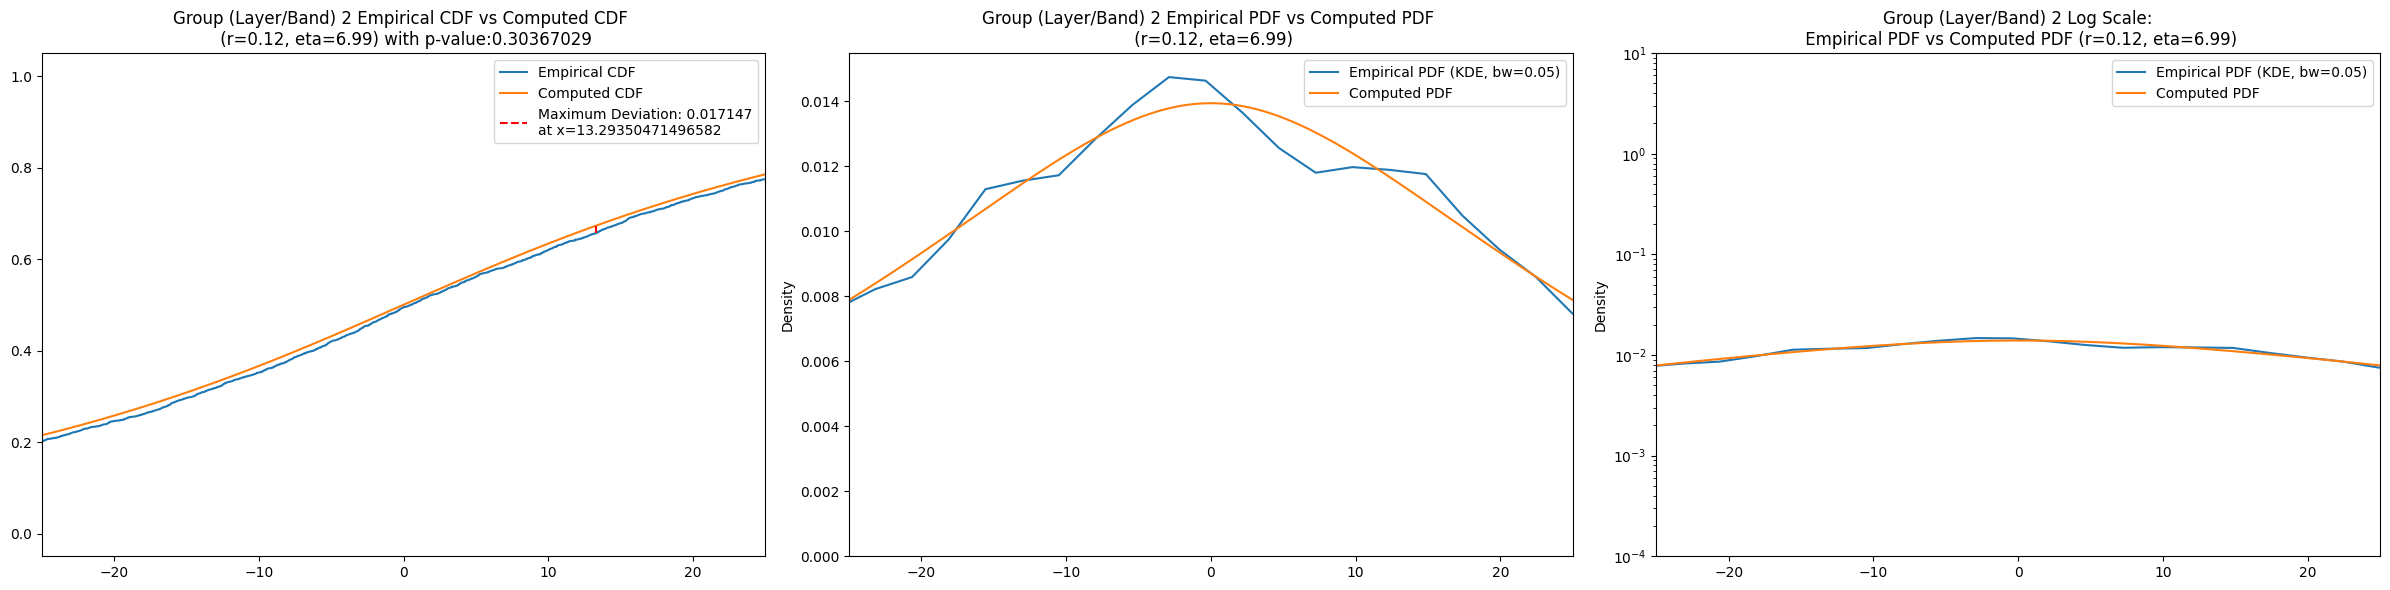

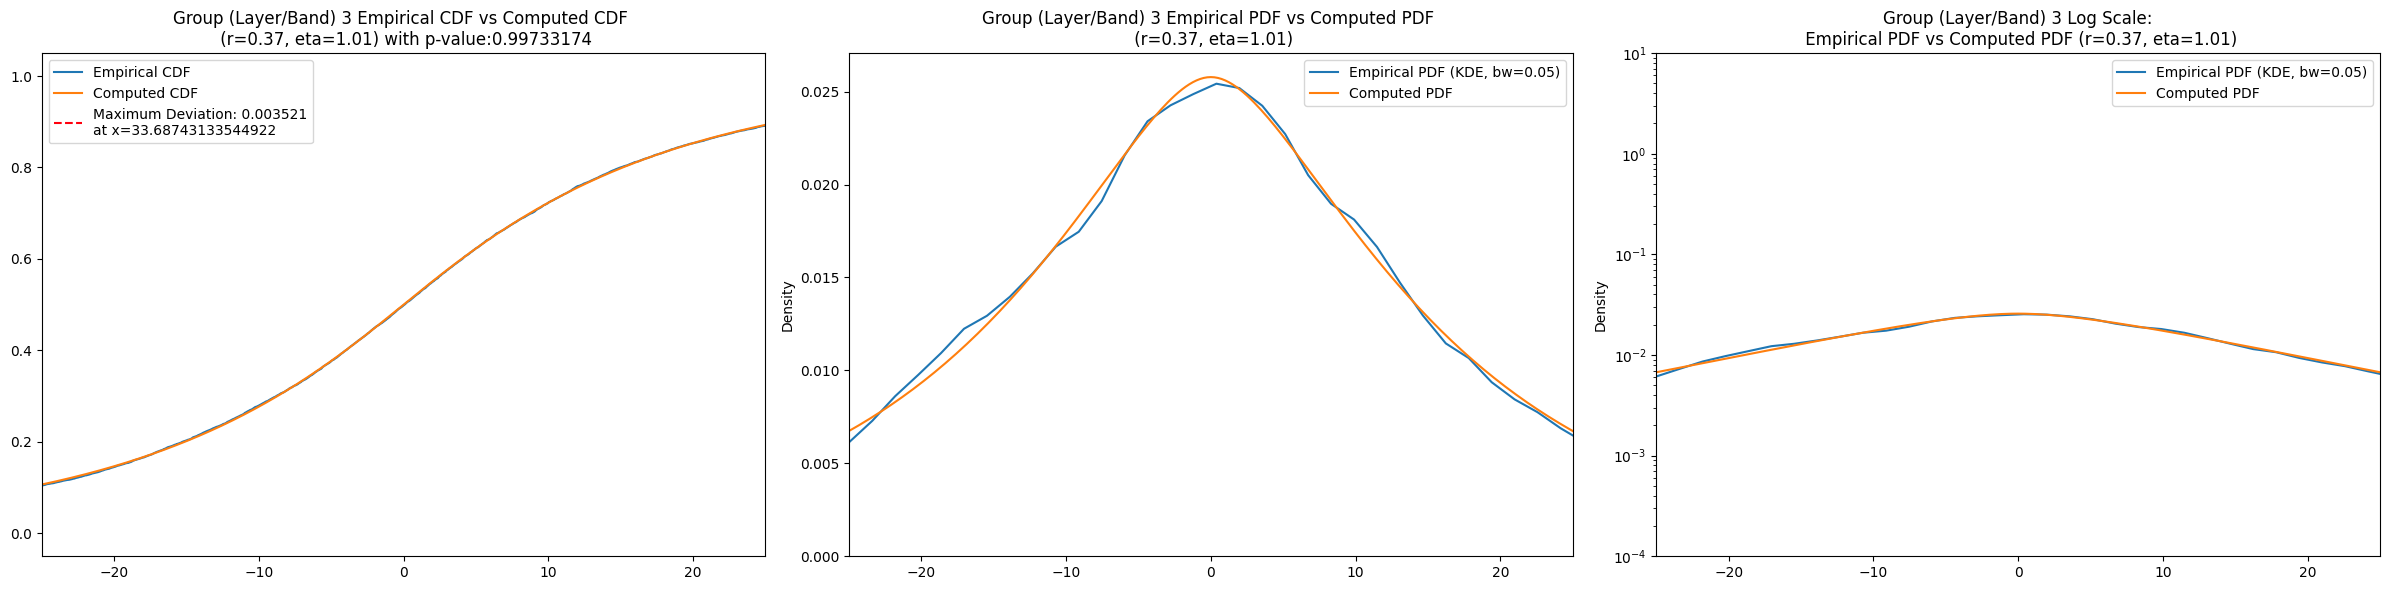

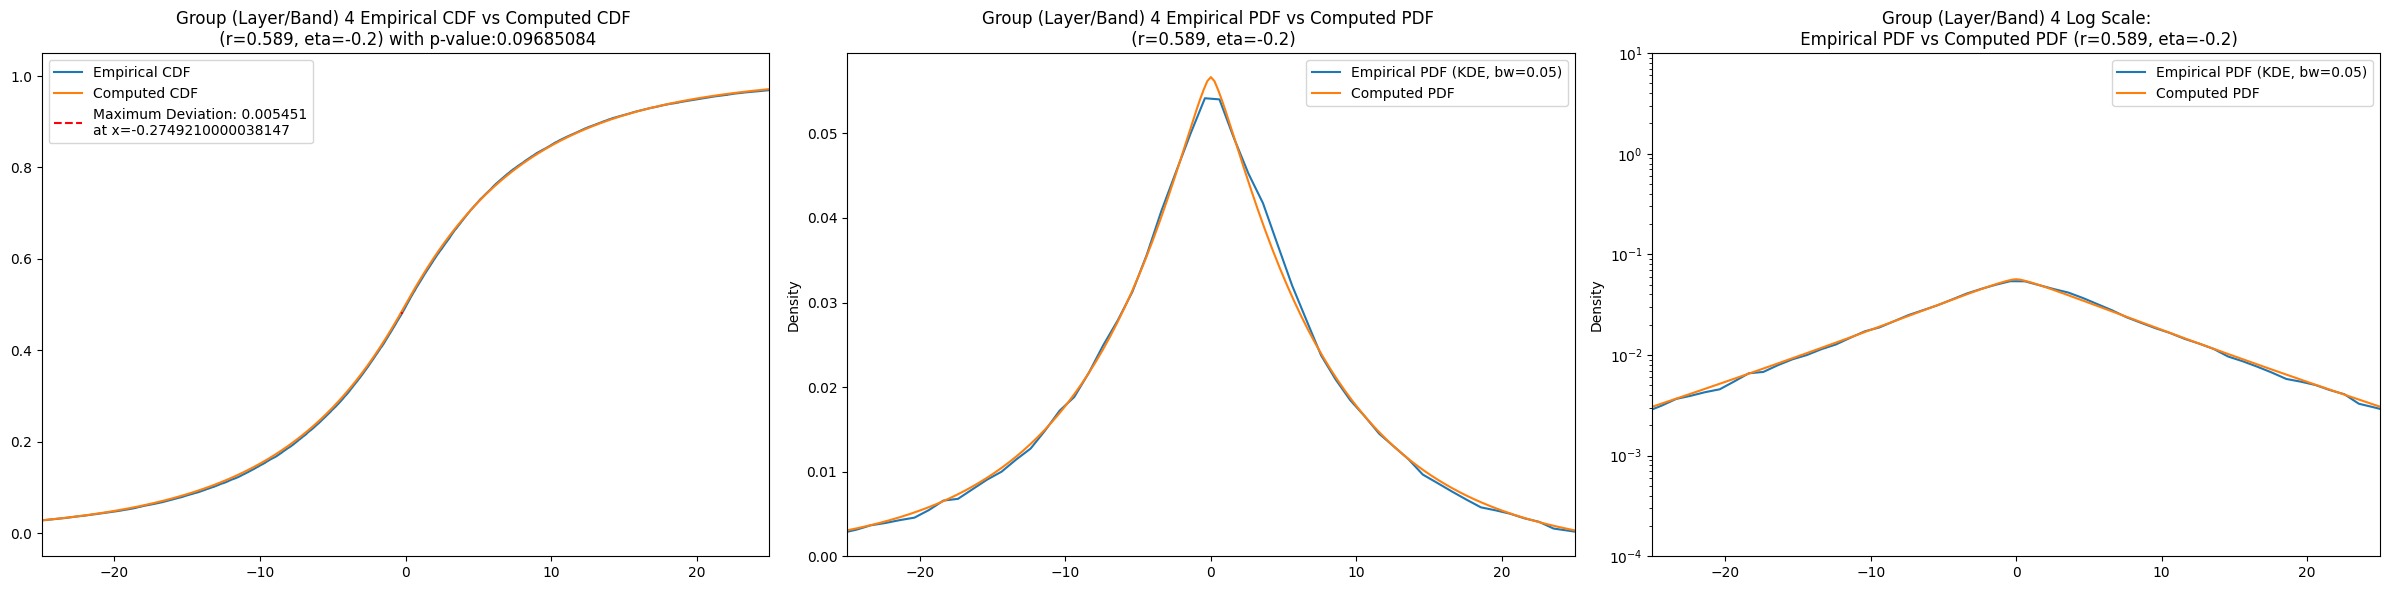

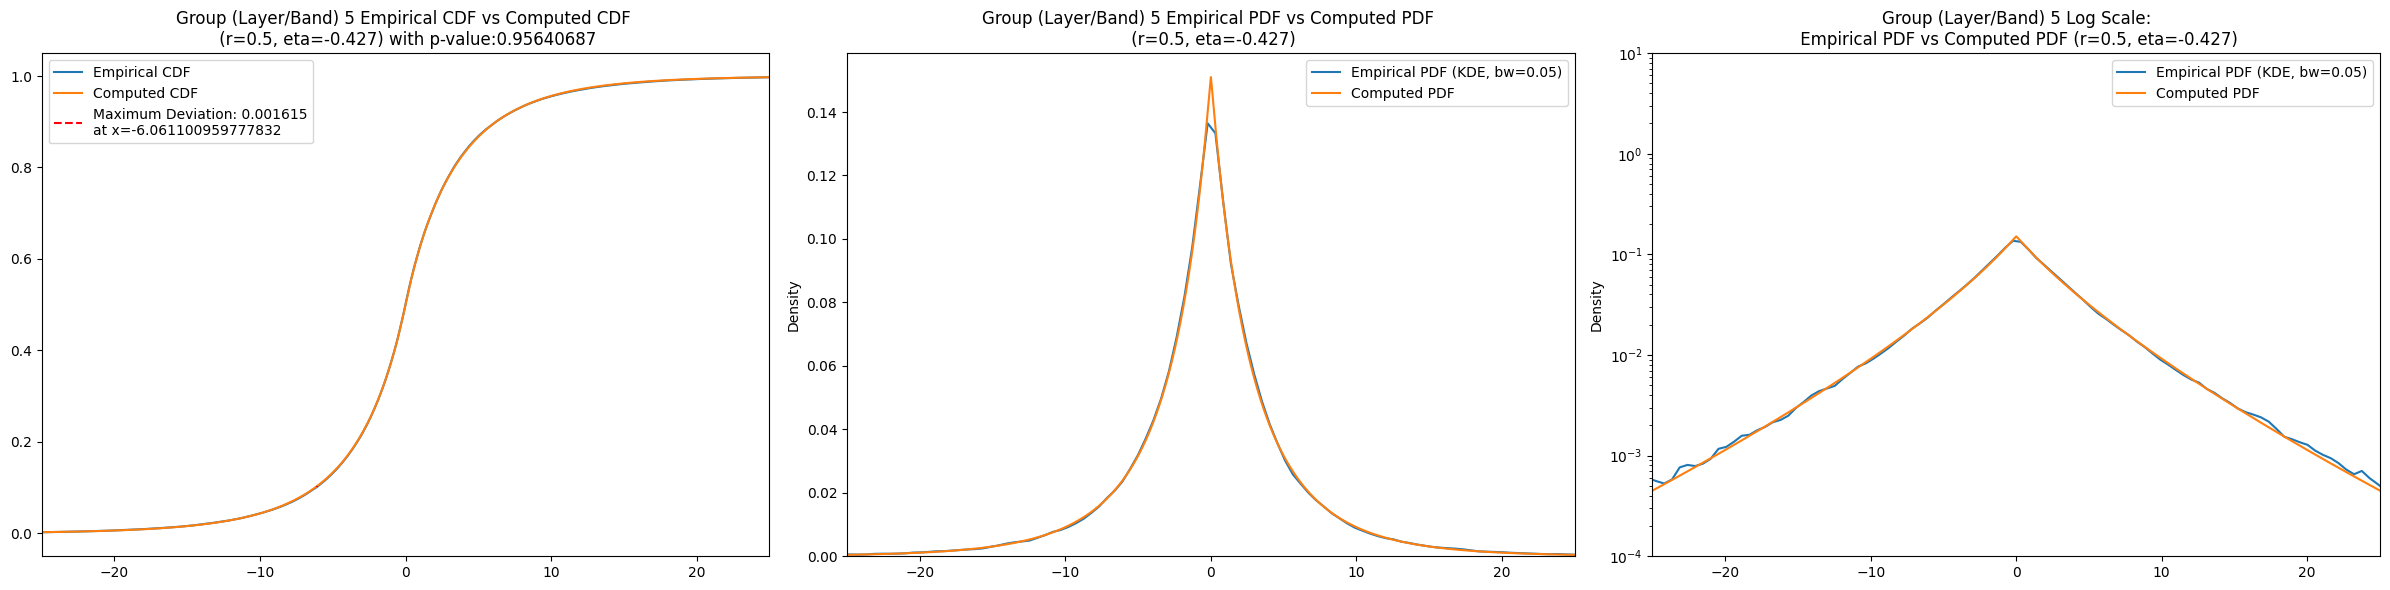

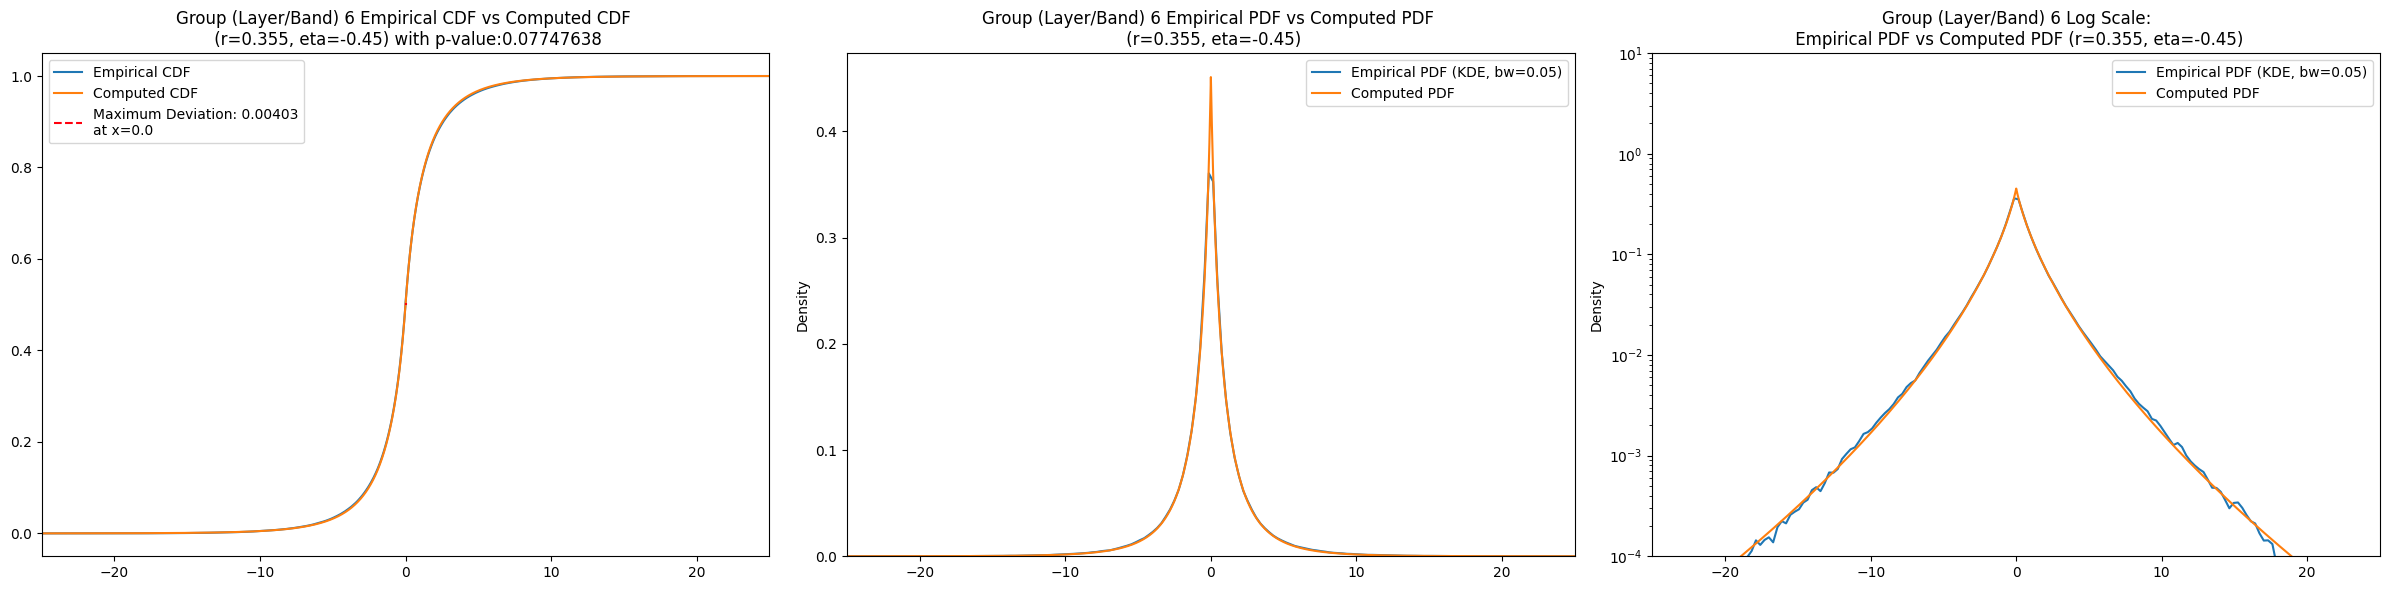

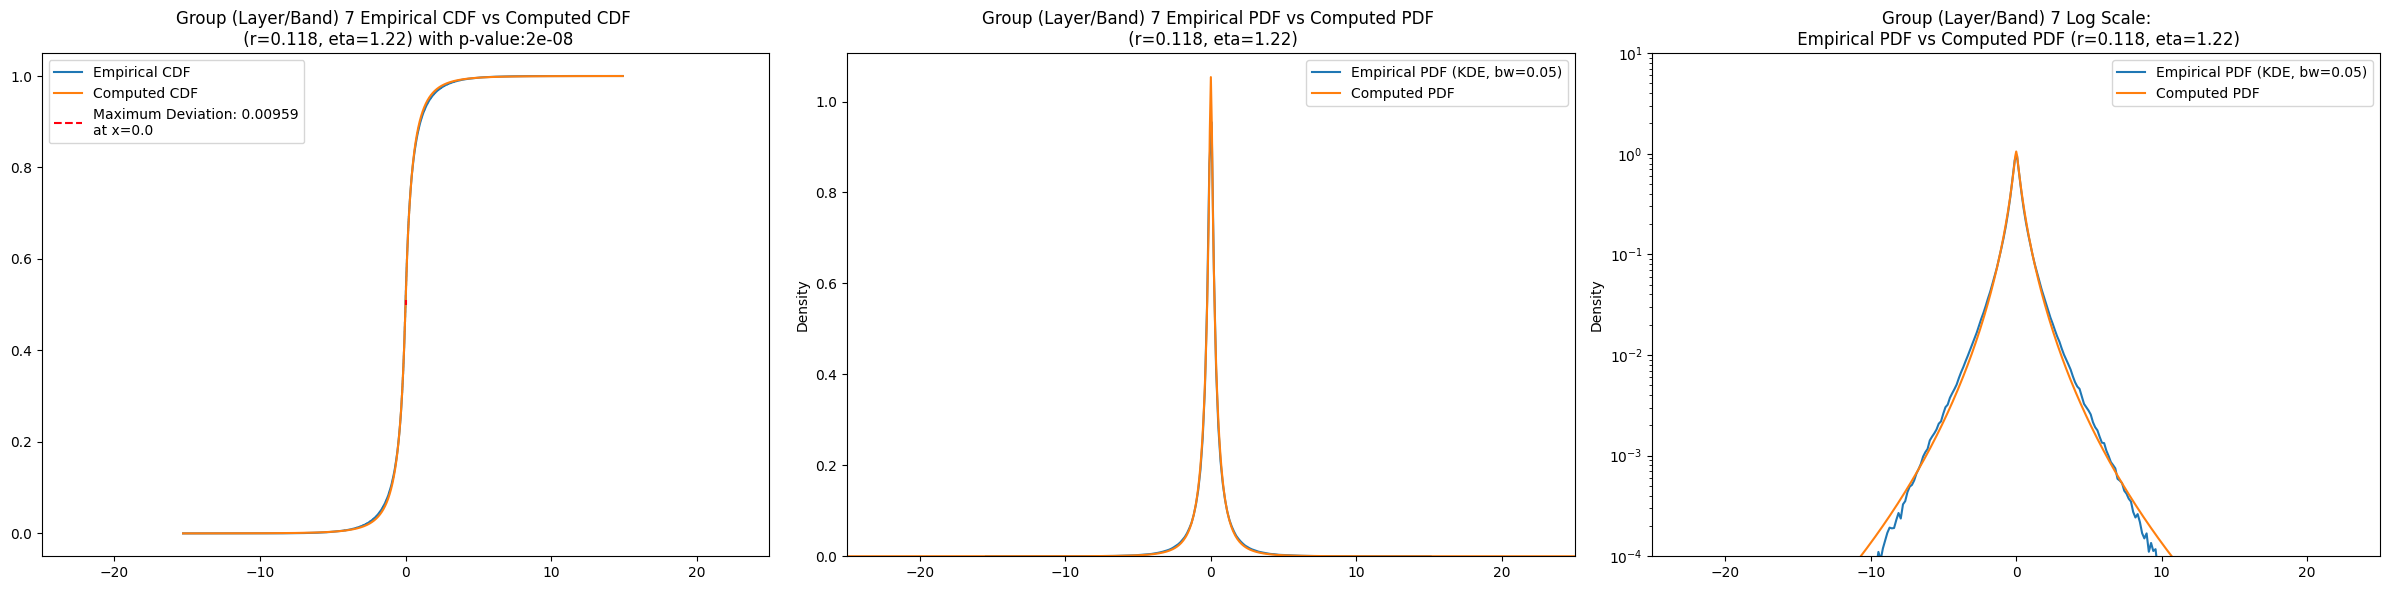

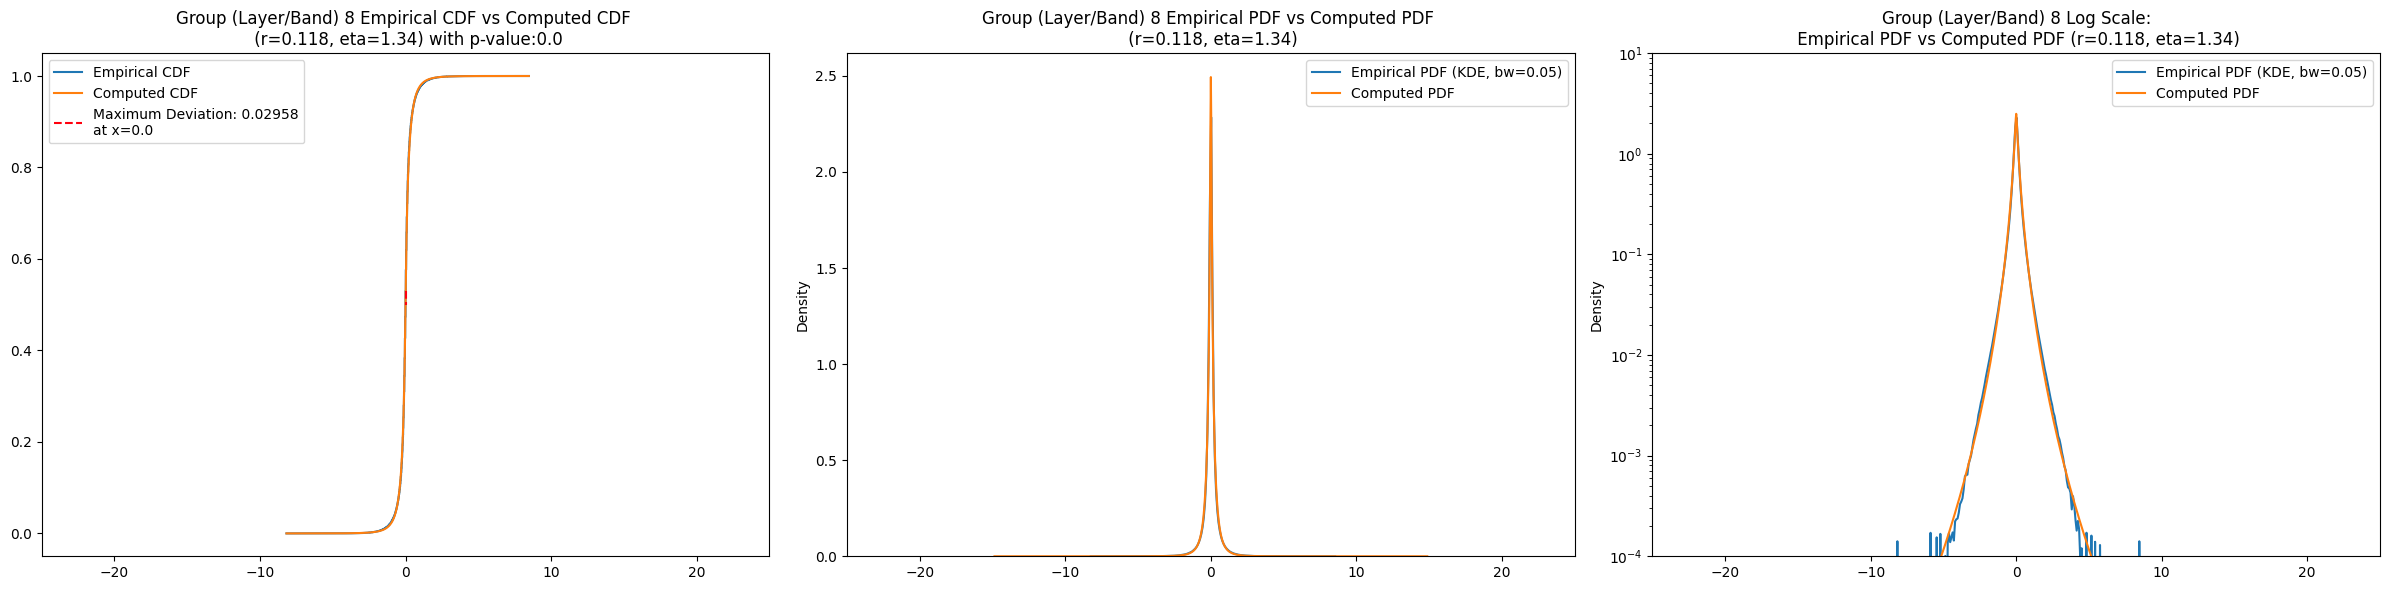

In [20]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [21]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [22]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        5.295139         3180.0       0.12         7.00   4.266123e-13  ...   
3        4.080620        12720.0       0.36         1.10   1.649470e+00  ...   
4        4.774097        50880.0       0.59        -0.20   3.224124e+01  ...   
5        6.967747       203520.0       0.50        -0.43   5.335612e+00  ...   
6       10.394491       814080.0       0.35        -0.40   1.355916e-01  ...   
7       15.655435      3256320.0       0.12         1.20   2.095827e-12  ...   
8       31.192720     13025280.0       0.12         1.40   2.048151e-13  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           32.943400              0.032992          1.925360e-03   
3           19.278300              0.026266          4.675180e-08   
4            9.585560              0.032821          4.729710e-48   
5            4.246750              0.037929         7.965330e-255   
6            1.671520              0.047234          0.000000e+00   
7            0.635292              0.054471          0.000000e+00   
8            0.245468              0.054655          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          30.544800             0.022702         7.426860e-02  25.284700   
3          16.696100             0.008254         3.495940e-01  13.636900   
4           8.430870             0.006066         4.711630e-02   6.901150   
5           3.722800             0.010595         2.845330e-20   3.004420   
6           1.464350             0.019746        3.784750e-276   1.172610   
7           0.557946             0.027110         0.000000e+00   0.443521   
8           0.213079             0.029580         0.000000e+00   0.165991   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018571   2.200210e-01          3.036709e-01  
3           0.011845   5.590880e-02          9.973317e-01  
4           0.009433   2.323800e-04          9.678561e-02  
5           0.013621   3.143460e-33          6.630125e-01  
6           0.021799   0.000000e+00          6.544400e-12  
7           0.027202   0.000000e+00         1.497431e-260  
8           0.030698   0.000000e+00          0.000000e+00  

[7 rows x 34 columns]

## Results

In [23]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [24]:
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        5.295139         3180.0       0.12         7.00   4.266123e-13  ...   
3        4.080620        12720.0       0.36         1.10   1.649470e+00  ...   
4        4.774097        50880.0       0.59        -0.20   3.224124e+01  ...   
5        6.967747       203520.0       0.50        -0.43   5.335612e+00  ...   
6       10.394491       814080.0       0.35        -0.40   1.355916e-01  ...   
7       15.655435      3256320.0       0.12         1.20   2.095827e-12  ...   
8       31.192720     13025280.0       0.12         1.40   2.048151e-13  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           32.943400              0.032992          1.925360e-03   
3           19.278300              0.026266          4.675180e-08   
4            9.585560              0.032821          4.729710e-48   
5            4.246750              0.037929         7.965330e-255   
6            1.671520              0.047234          0.000000e+00   
7            0.635292              0.054471          0.000000e+00   
8            0.245468              0.054655          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          30.544800             0.022702         7.426860e-02  25.284700   
3          16.696100             0.008254         3.495940e-01  13.636900   
4           8.430870             0.006066         4.711630e-02   6.901150   
5           3.722800             0.010595         2.845330e-20   3.004420   
6           1.464350             0.019746        3.784750e-276   1.172610   
7           0.557946             0.027110         0.000000e+00   0.443521   
8           0.213079             0.029580         0.000000e+00   0.165991   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018571   2.200210e-01          3.036709e-01  
3           0.011845   5.590880e-02          9.973317e-01  
4           0.009433   2.323800e-04          9.678561e-02  
5           0.013621   3.143460e-33          6.630125e-01  
6           0.021799   0.000000e+00          6.544400e-12  
7           0.027202   0.000000e+00         1.497431e-260  
8           0.030698   0.000000e+00          0.000000e+00  

[7 rows x 34 columns]

In [25]:
remove_directory(os.path.join(CWD, "groupCDFs"))
eng.quit()